# Module 3 Project - Whisky Sommelier
# Model Evaluation and Final Selection
By: **Maura Cerow**, **Rajeev Panwar** and **Bryan Santos**

This project aims to build the first module of a comprehensive whisky recommendation engine, an **automated whisky sommelier**. We would like this to act as a go-to "middle-man" between distributors, bars and consumers.

This notebook includes analysis of the models performed, further efforts of improving the scores (through hyperparameter tuning) and final selection.

## Our Modeling Process

Our modeling process is unique and follows these steps:
   1. Perform baseline modeling of each of the following methods then different metrics will be tallied. There will be no hyperparameter tuning for this part yet to be explained why below.
    - Logistic Regression
    - K-Nearest Neighbors
    - Decision Trees
    - Random Forest
    - Adaptive Boost
    - Gradient Boost
    - XGBoost
    - Naive Bayes
   2. Because we believe that we have indeed a significant class imbalance, we need to perform resampling. To do this, we then combine all of those methods with each of the following resampling techniques. Metrics will again be recorded.
    - Random Undersampling
    - Random Oversampling
    - Tomek Links
    - Cluster Centroids
    - SMOTE
    - SMOTE Tomek Links
   3. After getting the scores of all of those combinations, we will select the top five (5) models for further improvement and hyperparameter tuning, if applicable.
   4. All of the model evaluation, hyperparameter tuning and final selection will be performed in the succeeding notebook.
   5. Please note that there will be no analysis in this notebook as this is purely for summarizing all of the baseline scores of each classification method combined with different resampling techniques.
    
    

## Dataset

Here is the final dataset after webscraping, hypothesis testing, EDA and feature engineering.

**Target**  
- Whisky's country of origin: 
    - Scotland
    - Japan
    - USA
    - Canada
    - Ireland

**Features**
- Type (whether it is Single Malt, Blended, Rye, etc.)
- Price (ranging from 1 to 5 with 5 being the most expensive)
- Expert Score (critic score)
- User Rating (distiller.com user reviews)
- ABV (Alcohol By Volume)
- Description
- Style (ingredients)
- Maturing/Cask (whether matured in oak, sherry, etc.)
- Flavor Profiles (each having intensity scores ranging from 0 to 100):
    - *Smoky*
    - *Peaty*
    - *Spicy*
    - *Herbal*
    - *Oily*
    - *Full-Bodied*
    - *Rich*
    - *Sweet*
    - *Briny*
    - *Salty*
    - *Vanilla*
    - *Tart*
    - *Fruity*
    - *Floral* 
- Big-ticket items (classification of expensive varieties)
- Reputation (tagging of whether people love it or those with poor expert reviews)
- Bang-for-the-buck (expert score per price and user rating per price)
- Flavor intensity (whether intense or subtle)

## Package Imports and Data Load

In [1]:
### Needed libraries for Classification Modeling ###

### Basic packages ###
import numpy as np
import pandas as pd 

### Modeling ###
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
import itertools
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve
import imblearn
from sklearn.preprocessing import LabelBinarizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score



sns.set()

%matplotlib inline

### Suppress notebook warnings ###
import warnings
warnings.filterwarnings('ignore')

### Pandas settings to avoid exponential form and display all columns ###
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

/Users/Bryan/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
df = pd.read_csv("whiskey_feat_engineered.csv")

In [3]:
del df['Unnamed: 0']

Prepare dataframe that would summarize all the metrics from the models.

In [4]:
global results_df
results_df = pd.DataFrame(columns=['Model', 'Imbalance Handling','Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC Score'])
results_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score


## Functions for Reuse

These are all the functions for reuse separated into corresponding Data Science process. This makes for faster modeling and cleaner code.

### Data Pre-Processing

### Train Test Split

In [5]:
def data_split(features, target):
    '''
    This function splits the dataset into training and testing.
    
    Parameter: 
        Features: independent variables
        Target: dependent variable        
          
    Returns: 
        This returns the dataset split into four categories: features training and testing,
        target training and testing.
    
    '''
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42,test_size=0.2)
    return {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}

### Scaling

In [6]:
def scaler(features_train, features_test):

    '''
    This function scales/standardizes the features data with values 0 to 1. The resulting
    columns are best used when comparing weights.
    
    Parameter: 
        features_train: independent variables for training
        features_test: independent variables for testing       
          
    Returns: 
        This returns the standardized features.
    
    '''
    
    scaler = StandardScaler()  
    scaler.fit(features_train)
        
    X_train_scaled = scaler.transform(features_train)  
    X_test_scaled = scaler.transform(features_test)  
    
    return {'X_train_scaled': X_train_scaled, 'X_test_scaled': X_test_scaled}

### Clasification Methods

#### Logistic Regression

In [7]:
def logistic_regression(features, target):
    '''
    This function runs logistic regression and outputs the model used for fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
          
    Returns: 
        This returns the logistic regression model.
    '''
    logistic_regression_model = LogisticRegression().fit(features, target)
    return logistic_regression_model

#### K-Nearest Neighbors

In [8]:
def knn(features, target, n):
    '''
    This function runs k-nearest neighbor method and outputs the model used for fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
        n: number of neighbors parameter
    Returns: 
        This returns the knn model.
    '''
    knn_model = KNeighborsClassifier(n_neighbors=n)
    knn_model = knn_model.fit(features, target)
    return knn_model

In [9]:
def knn_best_model(features_train, target_train, features_test, target_test):
    '''
    This function runs k-nearest neighbor models and checks the best n_neighbors variable.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
          
    Returns: 
        This returns a comparison of knn results with different number of neighbors as
        parameter.
    '''
    k_range = list(range(1, 11))
    k_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(features_train, target_train)
        y_predict = knn.predict(features_test)
        score = f1_score(target_test, y_predict, average='weighted')
        k_scores.append(score)
        print("n = " + str(k) + " - " + str(score))
        
    plt.figure(figsize=(12, 6))  
    plt.plot(range(1, 11), k_scores, color='red', linestyle='dashed', marker='o',  
             markerfacecolor='blue', markersize=10)
    plt.title('F1 score by K Value')  
    plt.xlabel('K Value')  
    plt.ylabel('F1 Score') 
    plt.show()

#### Decision Trees

In [10]:
def decision_tree(features, target, depth):
    '''
    This function runs decision tree algorithm method and outputs the model used for 
    fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
        depth: maximum depth parameter
    Returns: 
        This returns the decision tree model.
    '''
    decision_tree_model = DecisionTreeClassifier(max_depth = depth)
    decision_tree_model.fit(features, target)    
    
    dot_data = StringIO()
    export_graphviz(decision_tree_model, out_file=dot_data,  
                    rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    Image(graph.create_png())
    return decision_tree_model

In [11]:
def decision_tree_best_model(features, target):
    '''
    This function runs decision tree models models and checks the best depth parameter.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
          
    Returns: 
        This returns a comparison of decision tree results with different depths as
        parameter.
    '''
    depth_range = range(1,10)
    val = []
    for depth in depth_range:
        ctree = DecisionTreeClassifier(max_depth = depth)
        depth_score = cross_val_score(ctree, features, target, cv = 10)
        val.append(depth_score.mean())
        print(str(depth_range) + " - " + str(depth_score.mean()))
    plt.figure(figsize = (10,10))
    plt.plot(depth_range, val)
    plt.xlabel('range of depth')
    plt.ylabel('cross validated values')
    plt.show()

#### Random Forest

In [12]:
def random_forest(features, target, params, baseline):
    '''
    This function runs random forest algorithm method and outputs the model used for 
    fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
        params: parameters after hypertuning
        baseline: set to True if to run initial, baseline model
    Returns: 
        This returns the random forest model.
    '''
    if (params == None) & (baseline == True):
        random_forest_model = RandomForestClassifier(random_state = 42)
        random_forest_model.fit(features, target)
        print(random_forest_model.get_params())
        return random_forest_model
    else:
        random_forest_model = RandomForestClassifier(**params, random_state = 42)
        random_forest_model.fit(features, target)
        return random_forest_model

#### Adaptive Boosting

In [13]:
def adaboost(features, target, params, baseline):
    '''
    This function runs adaptive boosting ensemble method and outputs the model used for 
    fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
        params: parameters after hypertuning
        baseline: set to True if to run initial, baseline model
    Returns: 
        This returns the adaptive boosting model.
    '''
    if (params == None) & (baseline == True):
        adaboost_model = AdaBoostClassifier(n_estimators=100, base_estimator= None,learning_rate=1, random_state = 42)
        adaboost_model.fit(features, target)
        print(adaboost_model)
        return adaboost_model
    else:
        adaboost_model = AdaBoostClassifier(**params)
        adaboost_model.fit(features, target)
        return adaboost_model

#### Gradient Boosting

In [14]:
def gradientboost(features, target, params, baseline):
    '''
    This function runs gradient boosting ensemble method and outputs the model used for 
    fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
        params: parameters after hypertuning
        baseline: set to True if to run initial, baseline model
    Returns: 
        This returns the gradient boosting model.
    '''
    if (params == None) & (baseline == True):
        params_baseline = {
        'n_estimators': 1,
        'max_depth': 1,
        'learning_rate': 1,
        'criterion': 'mse',
        'random_state': 42
        }

        gradient_boost_model = GradientBoostingClassifier(**params_baseline)
        gradient_boost_model.fit(features, target)
        return gradient_boost_model

    else:
        gradient_boost_model = GradientBoostingClassifier(**params, random_state = 42)
        gradient_boost_model.fit(features, target)
        return gradient_boost_model

#### Extreme Gradient Boosting (XGBoost)

In [15]:
def xgboost(features, target, params, baseline):
    '''
    This function runs xgboosting ensemble method and outputs the model used for 
    fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
        params: parameters after hypertuning
        baseline: set to True if to run initial, baseline model
    Returns: 
        This returns the xgboosting model.
    '''
    if (params == None) & (baseline == True):
        xgboost_model = XGBClassifier(n_jobs = -1)
        xgboost_model.fit(features, target)
        print(xgboost_model)
        return xgboost_model
    else:
        xgboost_model = XGBClassifier(**params)
        xgboost_model.fit(features, target)
        return xgboost_model

#### Naive Bayes

In [16]:
def naive_bayes(features, target):
    '''
    This function runs naive bayes method and outputs the model used for 
    fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       

    Returns: 
        This returns the naive bayes model.
    '''
    naive_bayes_model = GaussianNB()
    naive_bayes_model.fit(features, target)
    return naive_bayes_model

### Scoring and Evaluation

#### Grid Search Cross Validation

In [17]:
def grid_search_cv(model, features, target, params, n_jobs, cv):
    '''
    This function automatically runs grid search cross validation for hyperparameter tuning
    and determining the set of parameters that would produce the best results.
    
    Parameter: 
        model: model to be used for fitting
        features: independent variables
        target: dependent variable       
        params: parameters after hypertuning
        n_jobs: number of parallel jobs to run
        cv: number of cross-validation folds
        
    Returns: 
        This returns the best parameters.
    '''
    grid_search = GridSearchCV(estimator = model, param_grid = params, 
                          n_jobs=n_jobs, cv = cv)
    grid_search.fit(features, target)
    return grid_search.best_params_

#### Standard Scores

In [18]:
def score_model(model, handling, features_train, target_train, features_test, target_test):
    '''
    This function automatically runs the model inputted and calculates the following
    metrics: accuracy, precision, recall, and F1 score. Then this appends to the summary
    table initialized earlier that would list all results of all models run. This is for
    easier comparison and model evaluation. Finally, this also outputs the corresponding
    confusion matrix of the model.
    
    Parameter: 
        model: model to be used for fitting
        features_train: independent variables for training
        target_train: dependent variable for training      
        features_train: independent variables for testing
        target_train: dependent variable for testing  
        
    Returns: 
        This returns all the pertinent metrics, confusion matrix and appends to the summary
        dataframe.
    '''
    predictions = model.predict(features_test)
    accuracy = metrics.accuracy_score(target_test, predictions)
    precision = metrics.precision_score(target_test, predictions, average='weighted')
    recall = metrics.recall_score(target_test, predictions, average='weighted')
    f1 = metrics.f1_score(target_test, predictions, average='weighted')
    y_pred_prob = model.predict_proba(features_test)[:, 1]
    
    lb = LabelBinarizer()
    lb.fit(target_test)
    y_test = lb.transform(target_test)
    
    y_pred = model.predict(features_test)
    y_pred = lb.transform(y_pred)
    #return roc_auc_score(y_test, y_pred, average=average)
    
    roc_auc = metrics.roc_auc_score(y_test, y_pred, average="weighted")
    #cv = cross_val_score(model, features, target, cv=10, scoring='roc_auc').mean()
        
    cm = confusion_matrix(target_test, predictions)
    classes = ['Scotch', 'American', 'Canadian', 'Irish', 'Japanese']
    
    plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
    global results_df
    results_df = results_df.append({'Model': str(model).split('(')[0], 'Imbalance Handling' : handling , 'Accuracy' : accuracy, 'Precision' : precision, 'Recall': recall,  'F1 Score': f1, 'ROC AUC Score' : roc_auc} , ignore_index=True)

#### Feature Importance

In [19]:
def feature_importance(model):
#     importances = model.feature_importances_
#     std = np.std([model.feature_importances_ for tree in model.estimators_],
#                  axis=0)
#     indices = np.argsort(importances)[::-1]

#     # Print the feature ranking
#     print("Feature ranking:")

#     for f in range(X.shape[1]):
#         print("%d. " + X.column[f] + "feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

#     # Plot the feature importances of the forest
#     plt.figure()
#     plt.title("Feature importances")
#     plt.bar(range(X.shape[1]), importances[indices],
#            color="r", yerr=std[indices], align="center")
#     plt.xticks(range(X.shape[1]), indices)
#     plt.xlim([-1, X.shape[1]])
#     plt.show()

    feats = {} # a dict to hold feature_name: feature_importance
    for feature, importance in zip(df.columns, model.feature_importances_):
        feats[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90)


#### Confusion Matrix

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    This function automatically plots the confusion matrix.
    
    Parameter: 
        cm: confusion matrix from the scoring function
        normalize: True if to be normalized
        title: title of the confusion matrix
        cmap: plotting method
        
    Returns: 
        This returns a graphical confusion matrix
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Handling Class Imbalance

#### Random Undersampling

In [21]:
def random_undersampling(X_train, y_train):
    '''
    This function runs random undersampling to address class imbalance.
    
    Parameter: 
        X_train - independent variables for training
        y_train - dependent variable for training
        
    Returns: 
        This returns an updated dataset with random undersampling implemented.
    '''
    rus = RandomUnderSampler(random_state = 42)
    X_train, y_train = rus.fit_sample(X_train, y_train)
    return {'X_train': X_train, 'y_train': y_train}

#### Random Oversampling

In [22]:
def random_oversampling(X_train, y_train):
    '''
    This function runs random oversampling to address class imbalance.
    
    Parameter: 
        X_train - independent variables for training
        y_train - dependent variable for training
        
    Returns: 
        This returns an updated dataset with random oversampling implemented.
    '''
    ros = RandomOverSampler(random_state = 42)
    X_train, y_train = ros.fit_sample(X_train, y_train)
    return {'X_train': X_train, 'y_train': y_train}

#### Tomek Links

In [23]:
def tomek_links(X_train, y_train):
    '''
    This function runs tomek link undersampling to address class imbalance.
    
    Parameter: 
        X_train - independent variables for training
        y_train - dependent variable for training
        
    Returns: 
        This returns an updated dataset with tomek link undersampling implemented.
    '''
    tl = TomekLinks()
    X_train, y_train = tl.fit_sample(X_train, y_train)
    return {'X_train': X_train, 'y_train': y_train}

#### Cluster Centroids

In [24]:
def cluster_centroids(X_train, y_train):
    '''
    This function runs cluster centroids to address class imbalance.
    
    Parameter: 
        X_train - independent variables for training
        y_train - dependent variable for training
        
    Returns: 
        This returns an updated dataset with cluster centroids implemented.
    '''
    cc = ClusterCentroids(random_state = 42)
    X_train, y_train = cc.fit_sample(X_train, y_train)
    return {'X_train': X_train, 'y_train': y_train}

#### SMOTE

In [25]:
def smote(X_train, y_train):
    '''
    This function runs SMOTE to address class imbalance.
    
    Parameter: 
        X_train - independent variables for training
        y_train - dependent variable for training
        
    Returns: 
        This returns an updated dataset with SMOTE implemented.
    '''
    smote = SMOTE(random_state = 42)
    X_train, y_train = smote.fit_sample(X_train, y_train)
    return {'X_train': X_train, 'y_train': y_train}

#### SMOTETomek

In [26]:
def smote_tomek(X_train, y_train):
    '''
    This function runs a combination of SMOTE and tomek link to address class imbalance.
    
    Parameter: 
        X_train - independent variables for training
        y_train - dependent variable for training
        
    Returns: 
        This returns an updated dataset with SMOTE and tomek link implemented.
    '''
    smt = SMOTETomek(random_state = 42)
    X_train, y_train = smt.fit_sample(X_train, y_train)
    return {'X_train': X_train, 'y_train': y_train}

## Feature Selection

This is where the target and features are to be declared because all the modelling will happen automatically. 

In [27]:
df.columns

Index(['name', 'type', 'price', 'expert_score', 'user_rating', 'description',
       'abv', 'style', 'cask', 'review', 'smoky', 'peaty', 'spicy', 'herbal',
       'oily', 'full-bodied', 'rich', 'sweet', 'briny', 'salty', 'vanilla',
       'tart', 'fruity', 'floral', 'country', 'countries_cat', 'cask_category',
       'cask_cat_num', 'type_num', 'big_ticket', 'poor_performer',
       'people_love_this', 'escore_per_price', 'urating_per_price',
       'flavor_intensity'],
      dtype='object')

Set independent variables with dummy data through One Hot Encoding

In [28]:
dummies = pd.get_dummies(df['cask_category'], drop_first=True)
df = pd.concat([df, dummies], axis = 1)
dummies = pd.get_dummies(df['type'], drop_first=True)
df = pd.concat([df, dummies], axis = 1)

In [29]:
df.columns

Index(['name', 'type', 'price', 'expert_score', 'user_rating', 'description',
       'abv', 'style', 'cask', 'review', 'smoky', 'peaty', 'spicy', 'herbal',
       'oily', 'full-bodied', 'rich', 'sweet', 'briny', 'salty', 'vanilla',
       'tart', 'fruity', 'floral', 'country', 'countries_cat', 'cask_category',
       'cask_cat_num', 'type_num', 'big_ticket', 'poor_performer',
       'people_love_this', 'escore_per_price', 'urating_per_price',
       'flavor_intensity', 'bourbon_oak', 'bourbon_sherry', 'new', 'oak',
       'other', 'sherry', 'sherry_oak', 'used', 'wine', 'Bourbon', 'Canadian',
       'Flavored Whiskey', 'Grain Whiskey', 'Grain Whisky', 'Other Whiskey',
       'Rye', 'Single Malt', 'Single Pot Still', 'Tennessee', 'White'],
      dtype='object')

Set dependent variable

In [30]:
target = df['country']

Set independent variables

In [31]:
features_rf = df[['smoky', 'peaty', 'spicy', 'herbal', 'oily', 'full-bodied', 'rich', 'sweet', 
               'briny', 'salty', 'vanilla', 'tart', 'fruity', 'floral', 'type_num', 'price',
               'expert_score', 'user_rating', 'abv', 'cask_cat_num', 'big_ticket',  
               'poor_performer', 'people_love_this', 'escore_per_price', 'urating_per_price',
               'flavor_intensity']]

In [32]:
features = df[['price', 'expert_score', 'user_rating','abv', 'smoky', 'peaty',
       'spicy', 'herbal', 'oily', 'full-bodied', 'rich', 'sweet', 'briny', 'salty', 
       'vanilla', 'tart', 'fruity', 'floral', 'big_ticket', 'poor_performer',
       'people_love_this', 'escore_per_price', 'urating_per_price',
       'flavor_intensity', 'bourbon_oak', 'bourbon_sherry', 'new', 'oak',
       'other', 'sherry', 'sherry_oak', 'used', 'wine', 'Bourbon', 'Canadian',
       'Flavored Whiskey', 'Grain Whiskey', 'Grain Whisky', 'Other Whiskey',
       'Rye', 'Single Malt', 'Single Pot Still', 'Tennessee', 'White']]

In [33]:
df.shape

(2662, 55)

Train test split of the dataset as best practice prior to modeling.

In [34]:
split = data_split(features,target)
split_rf = data_split(features_rf, target)

## Top 5 Models

This section is where we select the top 5 models for further improvement and evaluation. We are choosing F1 score as the basis because we are treating Precision and Recall with equal importance. Our dataset is not sensitive like health/cancer data, so we are also treating all of our classes with equal priority. Also note that since this is a multi-class problem, we selected weighted as the averaging method over micro and macro. Micro tends to give more importance to majority of the data while macro does the opposite. Because we have imbalanced classes, we opted to use weighted as mentioned.

In [35]:
summary_df = pd.read_csv("results_summary.csv")

In [36]:
del summary_df['Unnamed: 0']

In [37]:
summary_df.head(5)

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839


In [38]:
sorted_df = summary_df.sort_values(by=['F1 Score'], ascending=False)

In [39]:
### Check to 10 models ###
sorted_df.head(10)

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
34,RandomForestClassifier,Random Oversampling,0.882,0.877,0.882,0.873,0.906
33,RandomForestClassifier,Random Oversampling,0.884,0.886,0.884,0.868,0.903
75,RandomForestClassifier,SMOTE,0.874,0.864,0.874,0.864,0.900
94,GradientBoostingClassifier,SMOTE Tomek,0.867,0.862,0.867,0.864,0.906
38,GradientBoostingClassifier,Random Oversampling,0.872,0.866,0.872,0.863,0.901
10,GradientBoostingClassifier,None,0.878,0.877,0.878,0.863,0.900
80,GradientBoostingClassifier,SMOTE,0.867,0.857,0.867,0.861,0.904
40,XGBClassifier,Random Oversampling,0.857,0.864,0.857,0.860,0.902
82,XGBClassifier,SMOTE,0.859,0.856,0.859,0.856,0.899
11,XGBClassifier,None,0.869,0.870,0.869,0.853,0.893


As seen in the table, the highest classification methods are the ensemble ones particularly Random Forst, Gradient Boost and XGBoost. Furthermore, given that our minority classes only have over 100 datapoints as opposed to the majority classes which have more than 1,000, oversampling methods such as Random Oversampling, SMOTE and SMOTE Tomek garnered higher scores versus undersampling techniques. 

## Models and Techniques Analysis

In [40]:
models_df = summary_df.groupby('Model', as_index=False).agg({'F1 Score': ['mean']})
models_df.columns = models_df.columns.droplevel(0)
models_df.columns = ['model', 'mean']
models_df

,model,mean
0,AdaBoostClassifier,0.667
1,DecisionTreeClassifier,0.634
2,GaussianNB,0.504
3,GradientBoostingClassifier,0.677
4,KNeighborsClassifier,0.757
5,LogisticRegression,0.620
6,RandomForestClassifier,0.734
7,XGBClassifier,0.739


No handles with labels found to put in legend.


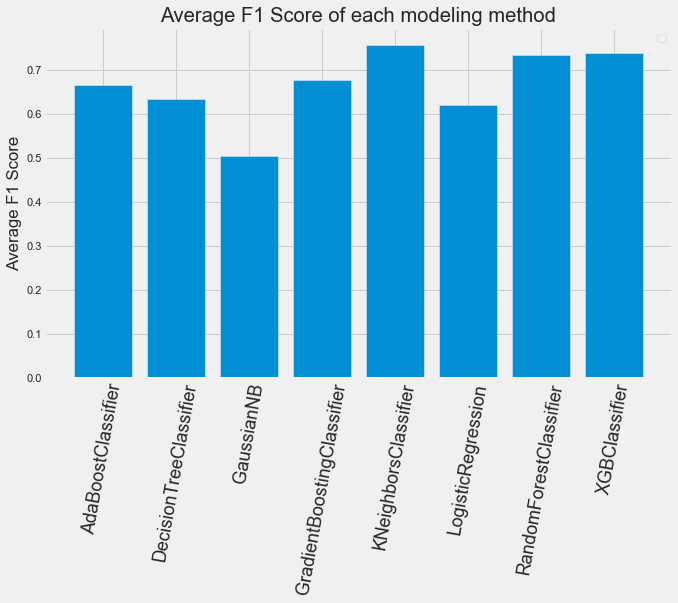

In [41]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(models_df["model"],models_df["mean"])

ax.set_xticklabels(models_df["model"], rotation=80, fontsize=18)

ax.set_ylabel("Average F1 Score")
ax.set_title('Average F1 Score of each modeling method')
ax.legend()

plt.show()

It is interesting to see that three ensemble methods are in the Top 4 and other one is KNN. This proves that they can be truly powerful in classification problems. Naive Bayes performed the poorest.

It is particularly strange that KNN has the highest mean even though none of its models made it to the top 10.

In [42]:
resample_df = summary_df.groupby('Imbalance Handling', as_index=False).agg({'F1 Score': ['mean']})
resample_df.columns = resample_df.columns.droplevel(0)
resample_df.columns = ['technique', 'mean']
resample_df

,technique,mean
0,Cluster Centroids,0.253
1,None,0.782
2,Random Oversampling,0.746
3,Random Undersampling,0.663
4,SMOTE,0.775
5,SMOTE Tomek,0.772
6,Tomek Links,0.780


No handles with labels found to put in legend.


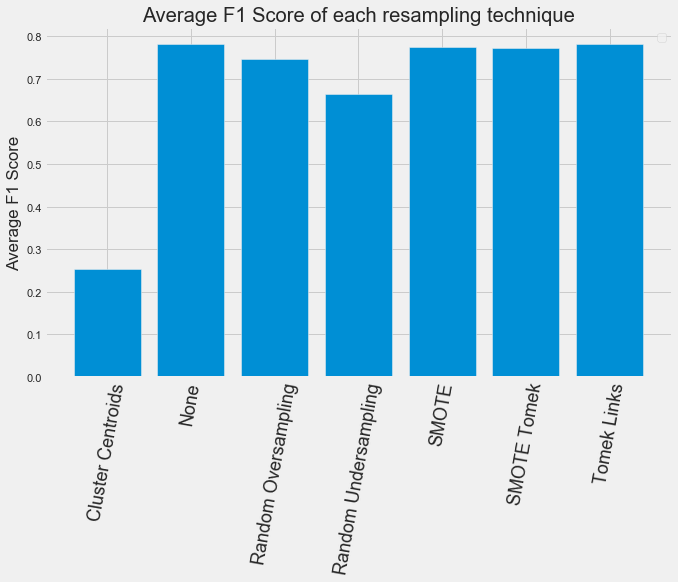

In [43]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(resample_df["technique"],resample_df["mean"])

ax.set_xticklabels(resample_df["technique"], rotation=80, fontsize=18)

ax.set_ylabel("Average F1 Score")
ax.set_title('Average F1 Score of each resampling technique')
ax.legend()

plt.show()

The result here is surprising that no resampling managed to score clost to the other techniques even though it was apparent that there was a significant class imbalance. Tomek Links while an undersampling technique also managed to score high. Cluster Centroids managed to do very poorly. Could this mean that is is hard to cluster our datapoints?

## Hypertuning and Final Scores

This section is where we perform hyperparameter tuning for the top 5 models to finally assess which one is the best in predicting our multi-class problem. Here are our guidelines / process when hyper tuning:

**Random Forest**
- max depth: the maximum option is set to 10 to avoid overfitting
- minimum sample split: set to the absolute minimum of 2, to ensure that the model still splits if necessary
- minimum sample leaf: set to the absolute minimum of 1, same reason as above
- n estimators: 200 is the maximum option because by choosing more number of trees, the time complexity of the Random Forest model also increases and the results can only go as high
- max features set to auto so the gridsearch can determine the best one automatically

**Gradient Boost**
- loss: set to deviance because exponential will not work on a multi-class problem
- learning rate: lower values are generally preferred as they make the model robust to the specific characteristics of tree and thus allowing it to generalize well but can be computationally expensive. Generally the default value of 0.1 works but somewhere between 0.05 to 0.2 should work for different problems as per our source.
- minimum sample split: set to the absolute minimum of 2, to ensure that the model still splits if necessary
- minimum sample leaf: set to the absolute minimum of 1, same reason as above
- max depth: the maximum option is set to 10 to avoid overfitting
- max features: one option is set to auto so the gridsearch can determine the best one automatically
- subsample: .8 as the commonly used start value
- n estimators: 200 is the maximum option because by choosing more number of trees, the time complexity of the Random Forest model also increases and the results can only go as high


### Model 1: Random Forest + Random Oversampling

In [44]:
balanced = random_oversampling(split['X_train'], split['y_train'])
balanced_rf = random_oversampling(split_rf['X_train'], split_rf['y_train'])

In [45]:
random_forest_model = random_forest(balanced_rf['X_train'], balanced_rf['y_train'], None, True)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Confusion Matrix, without normalization
[[187  13   0   1   0]
 [  4 237   0   0   1]
 [  0   3  28   0   0]
 [ 16   7   0  11   0]
 [ 14   2   1   0   8]]


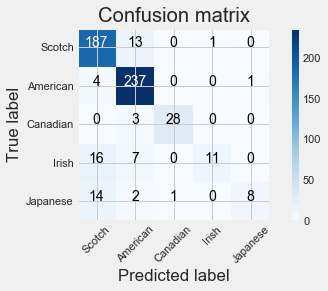

In [46]:
score_model(random_forest_model, "Random Oversampling", balanced_rf['X_train'], balanced_rf['y_train'], split_rf['X_test'], split_rf['y_test'])

In [47]:
results_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,RandomForestClassifier,Random Oversampling,0.884,0.886,0.884,0.868,0.903


In [48]:
n_estimators = [10, 50, 100, 150, 200]
max_features = ['auto', 'sqrt','log2']
max_depth =[2,5,7,10]
min_samples_leaf=[1]
min_samples_split=[2]
bootstrap = [True, False]

# Create the random grid
param_grid = {  'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                'min_samples_split': min_samples_split,
                'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 50, 100, 150, 200], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [2, 5, 7, 10], 'min_samples_leaf': [1], 'min_samples_split': [2], 'bootstrap': [True, False]}


In [49]:
params = grid_search_cv(random_forest_model, features, target, param_grid, 4, 5)
print (params)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [50]:
random_forest_model = random_forest(balanced_rf['X_train'], balanced_rf['y_train'], params, False)

Confusion Matrix, without normalization
[[183  11   0   7   0]
 [  5 233   2   1   1]
 [  0   1  30   0   0]
 [ 15   6   0  13   0]
 [ 10   3   0   1  11]]


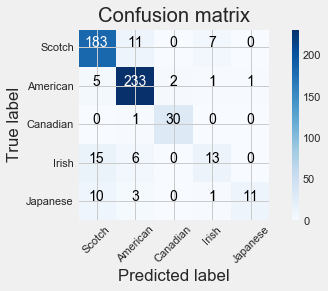

In [51]:
score_model(random_forest_model, "Random Oversampling", balanced_rf['X_train'], balanced_rf['y_train'], split_rf['X_test'], split_rf['y_test'])

In [52]:
results_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,RandomForestClassifier,Random Oversampling,0.884,0.886,0.884,0.868,0.903
1,RandomForestClassifier,Random Oversampling,0.882,0.876,0.882,0.873,0.907


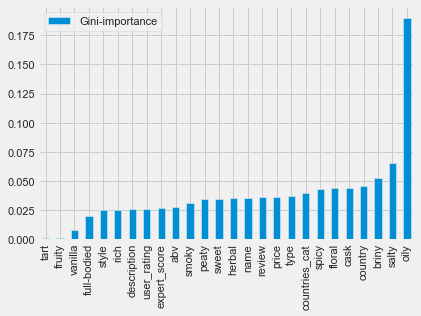

In [53]:
feature_importance(random_forest_model)

### Model 2: Random Forest + SMOTE

In [54]:
balanced = smote(split['X_train'], split['y_train'])
balanced_rf = smote(split_rf['X_train'], split_rf['y_train'])

In [55]:
random_forest_model = random_forest(balanced_rf['X_train'], balanced_rf['y_train'], None, True)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Confusion Matrix, without normalization
[[180  11   0   8   2]
 [  5 235   0   1   1]
 [  0   2  29   0   0]
 [ 15   8   0  11   0]
 [ 12   2   0   0  11]]


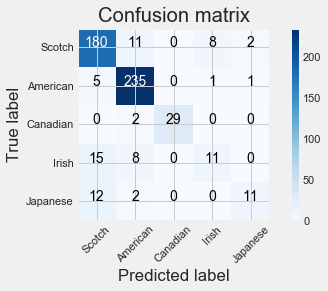

In [56]:
score_model(random_forest_model, "SMOTE", balanced_rf['X_train'], balanced_rf['y_train'], split_rf['X_test'], split_rf['y_test'])

In [57]:
results_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,RandomForestClassifier,Random Oversampling,0.884,0.886,0.884,0.868,0.903
1,RandomForestClassifier,Random Oversampling,0.882,0.876,0.882,0.873,0.907
2,RandomForestClassifier,SMOTE,0.874,0.864,0.874,0.864,0.900


In [58]:
n_estimators = [10, 50, 100, 150, 200]
max_features = ['auto', 'sqrt','log2']
max_depth =[2,5,7,10]
min_samples_leaf=[1]
min_samples_split=[2]
bootstrap = [True, False]

# Create the random grid
param_grid = {  'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                'min_samples_split': min_samples_split,
                'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 50, 100, 150, 200], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [2, 5, 7, 10], 'min_samples_leaf': [1], 'min_samples_split': [2], 'bootstrap': [True, False]}


In [59]:
params = grid_search_cv(random_forest_model, features, target, param_grid, 4, 5)
print (params)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [60]:
random_forest_model = random_forest(balanced_rf['X_train'], balanced_rf['y_train'], params, False)

Confusion Matrix, without normalization
[[172  12   0  13   4]
 [  4 233   3   1   1]
 [  0   2  29   0   0]
 [ 15   8   0  11   0]
 [ 12   3   0   0  10]]


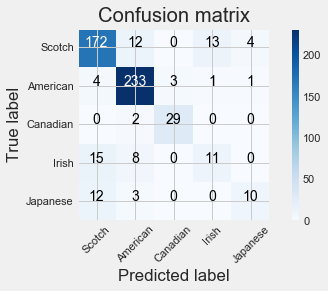

In [61]:
score_model(random_forest_model, "SMOTE", balanced_rf['X_train'], balanced_rf['y_train'], split_rf['X_test'], split_rf['y_test'])

In [62]:
results_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,RandomForestClassifier,Random Oversampling,0.884,0.886,0.884,0.868,0.903
1,RandomForestClassifier,Random Oversampling,0.882,0.876,0.882,0.873,0.907
2,RandomForestClassifier,SMOTE,0.874,0.864,0.874,0.864,0.900
3,RandomForestClassifier,SMOTE,0.854,0.842,0.854,0.845,0.888


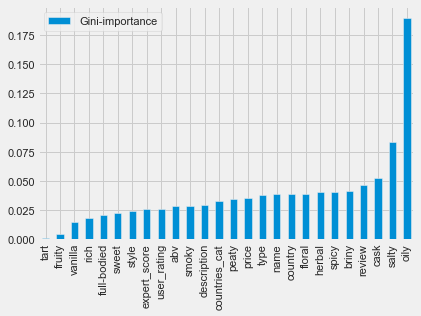

In [63]:
feature_importance(random_forest_model)

### Model 3: Gradient Boost + SMOTETomek

In [64]:
balanced = smote_tomek(split['X_train'], split['y_train'])
balanced_rf = smote_tomek(split_rf['X_train'], split_rf['y_train'])

In [65]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], None, True)

Confusion Matrix, without normalization
[[156   0   0  23  22]
 [ 15 112   0  90  25]
 [  1   0  29   0   1]
 [ 11   0   0  16   7]
 [ 10   0   0   1  14]]


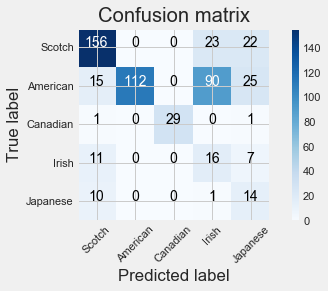

In [66]:
score_model(gradient_boost_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [67]:
results_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,RandomForestClassifier,Random Oversampling,0.884,0.886,0.884,0.868,0.903
1,RandomForestClassifier,Random Oversampling,0.882,0.876,0.882,0.873,0.907
2,RandomForestClassifier,SMOTE,0.874,0.864,0.874,0.864,0.900
3,RandomForestClassifier,SMOTE,0.854,0.842,0.854,0.845,0.888
4,GradientBoostingClassifier,SMOTE Tomek,0.614,0.834,0.614,0.669,0.776


In [68]:
param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.1, 0.2],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "max_depth":[3,5,10],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse"],
    "subsample":[1.0],
    "n_estimators":[50, 100, 200]
    }

In [69]:
params = grid_search_cv(gradient_boost_model, features, target, param_grid, 4, 5)
print (params)

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 1.0}


In [70]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[173   3   3  13   9]
 [ 12 224   3   3   0]
 [  1   1  29   0   0]
 [ 13   5   0  16   0]
 [ 12   1   0   1  11]]


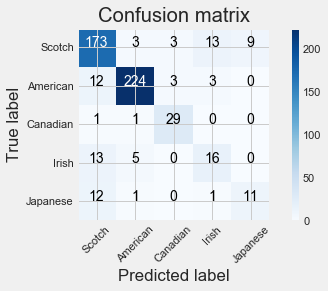

In [71]:
score_model(gradient_boost_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [72]:
results_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,RandomForestClassifier,Random Oversampling,0.884,0.886,0.884,0.868,0.903
1,RandomForestClassifier,Random Oversampling,0.882,0.876,0.882,0.873,0.907
2,RandomForestClassifier,SMOTE,0.874,0.864,0.874,0.864,0.900
3,RandomForestClassifier,SMOTE,0.854,0.842,0.854,0.845,0.888
4,GradientBoostingClassifier,SMOTE Tomek,0.614,0.834,0.614,0.669,0.776
5,GradientBoostingClassifier,SMOTE Tomek,0.850,0.849,0.850,0.849,0.894


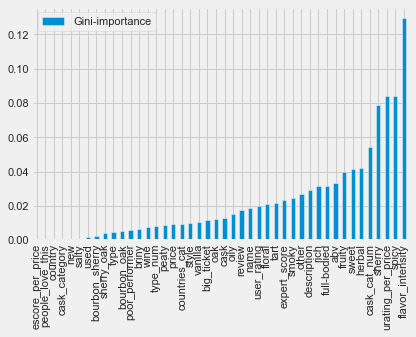

In [73]:
feature_importance(gradient_boost_model)

### Model 4: Gradient Boosting + Random Oversampling

In [74]:
balanced = random_oversampling(split['X_train'], split['y_train'])
balanced_rf = random_oversampling(split_rf['X_train'], split_rf['y_train'])

In [75]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], None, True)

Confusion Matrix, without normalization
[[156   0   0  24  21]
 [ 15 112   0  90  25]
 [  1   0  29   0   1]
 [ 11   0   0  17   6]
 [ 10   0   0   1  14]]


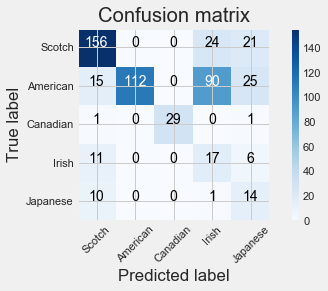

In [76]:
score_model(gradient_boost_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [77]:
results_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,RandomForestClassifier,Random Oversampling,0.884,0.886,0.884,0.868,0.903
1,RandomForestClassifier,Random Oversampling,0.882,0.876,0.882,0.873,0.907
2,RandomForestClassifier,SMOTE,0.874,0.864,0.874,0.864,0.900
3,RandomForestClassifier,SMOTE,0.854,0.842,0.854,0.845,0.888
4,GradientBoostingClassifier,SMOTE Tomek,0.614,0.834,0.614,0.669,0.776
5,GradientBoostingClassifier,SMOTE Tomek,0.850,0.849,0.850,0.849,0.894
6,GradientBoostingClassifier,Random Oversampling,0.615,0.835,0.615,0.669,0.777


In [78]:
param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.1],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "max_depth":[10],
    "max_features":["auto"],
    "criterion": ["friedman_mse"],
    "subsample":[0.8],
    "n_estimators":[100]
    }

In [79]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[148   2   1  29  21]
 [ 14 212   3  11   2]
 [  1   1  29   0   0]
 [ 11   1   0  21   1]
 [  6   1   0   0  18]]


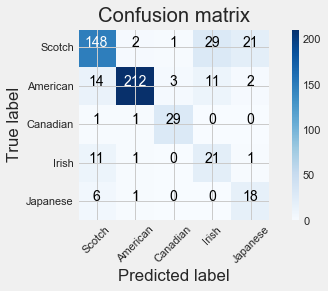

In [80]:
score_model(gradient_boost_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [81]:
results_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,RandomForestClassifier,Random Oversampling,0.884,0.886,0.884,0.868,0.903
1,RandomForestClassifier,Random Oversampling,0.882,0.876,0.882,0.873,0.907
2,RandomForestClassifier,SMOTE,0.874,0.864,0.874,0.864,0.900
3,RandomForestClassifier,SMOTE,0.854,0.842,0.854,0.845,0.888
4,GradientBoostingClassifier,SMOTE Tomek,0.614,0.834,0.614,0.669,0.776
5,GradientBoostingClassifier,SMOTE Tomek,0.850,0.849,0.850,0.849,0.894
6,GradientBoostingClassifier,Random Oversampling,0.615,0.835,0.615,0.669,0.777
7,GradientBoostingClassifier,Random Oversampling,0.803,0.847,0.803,0.819,0.876


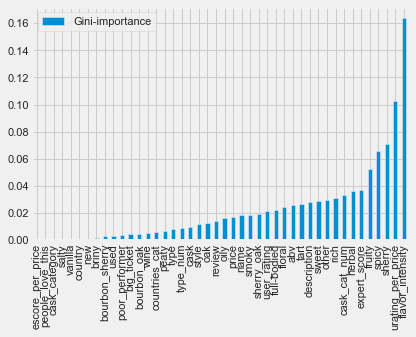

In [82]:
feature_importance(gradient_boost_model)

### Model 5: Gradient Boosting + No Resampling

In [83]:
gradient_boost_model = gradientboost(split['X_train'], split['y_train'], None, True)

Confusion Matrix, without normalization
[[156  39   0   0   6]
 [ 15 227   0   0   0]
 [  1   1  29   0   0]
 [ 11  18   0   5   0]
 [ 10  14   0   0   1]]


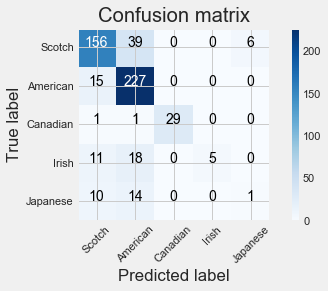

In [84]:
score_model(gradient_boost_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [85]:
results_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,RandomForestClassifier,Random Oversampling,0.884,0.886,0.884,0.868,0.903
1,RandomForestClassifier,Random Oversampling,0.882,0.876,0.882,0.873,0.907
2,RandomForestClassifier,SMOTE,0.874,0.864,0.874,0.864,0.900
3,RandomForestClassifier,SMOTE,0.854,0.842,0.854,0.845,0.888
4,GradientBoostingClassifier,SMOTE Tomek,0.614,0.834,0.614,0.669,0.776
5,GradientBoostingClassifier,SMOTE Tomek,0.850,0.849,0.850,0.849,0.894
6,GradientBoostingClassifier,Random Oversampling,0.615,0.835,0.615,0.669,0.777
7,GradientBoostingClassifier,Random Oversampling,0.803,0.847,0.803,0.819,0.876
8,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


In [86]:
param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.1],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "max_depth":[10],
    "max_features":["auto"],
    "criterion": ["friedman_mse"],
    "subsample":[0.8],
    "n_estimators":[100]
    }


# print(param_grid)

In [87]:
gradient_boost_model = gradientboost(split['X_train'], split['y_train'], params, False)

Confusion Matrix, without normalization
[[194   5   0   2   0]
 [ 13 229   0   0   0]
 [  1   1  29   0   0]
 [ 17   8   0   9   0]
 [ 16   1   0   0   8]]


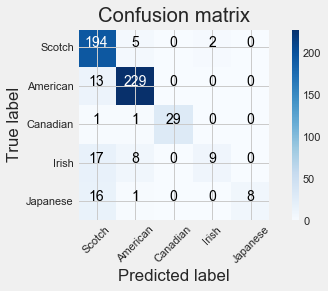

In [88]:
score_model(gradient_boost_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [89]:
results_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,RandomForestClassifier,Random Oversampling,0.884,0.886,0.884,0.868,0.903
1,RandomForestClassifier,Random Oversampling,0.882,0.876,0.882,0.873,0.907
2,RandomForestClassifier,SMOTE,0.874,0.864,0.874,0.864,0.900
3,RandomForestClassifier,SMOTE,0.854,0.842,0.854,0.845,0.888
4,GradientBoostingClassifier,SMOTE Tomek,0.614,0.834,0.614,0.669,0.776
5,GradientBoostingClassifier,SMOTE Tomek,0.850,0.849,0.850,0.849,0.894
6,GradientBoostingClassifier,Random Oversampling,0.615,0.835,0.615,0.669,0.777
7,GradientBoostingClassifier,Random Oversampling,0.803,0.847,0.803,0.819,0.876
8,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815
9,GradientBoostingClassifier,None,0.880,0.887,0.880,0.863,0.901


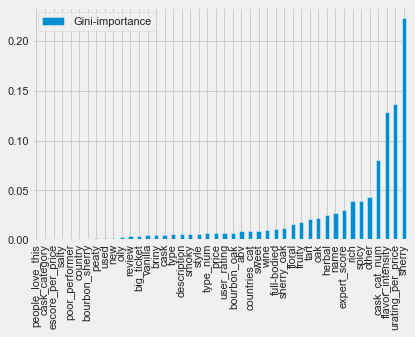

In [90]:
feature_importance(gradient_boost_model)

## Analysis and Observations

**The best model is the hypertuned RANDOM FOREST + RANDOM OVERSAMPLING**

1. Even though we know that one of the models without resampling reached the top 5, we believed that resampling because of the significant imbalance was still important. We are proven right with the winning model which uses Random Oversampling.

2. It is interesting that these top models had different top features in terms of importance. The winning models had the flavor profile: Oily as the top but the other models had one of the categorical cask variables and one of the new features engineered - flavor intesity. This shows the our feature engineering was effective to say the least.

3. Our top models show a very balanced precision, recall and even F1 score. This is based on our treatment of recall and precision (and therefore Type I and Type II erros) as equal. 